In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch 
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [8]:
file_name = 'bengali-train-low'
evaluate_file = 'bengali-dev'
test_file = 'bengali-test'

def file_preprocess(file_name):
    
    # from google.colab import files
    # uploaded = files.upload()
    
    pandas_holder = pd.read_csv(file_name, sep='\t', names=['word', 'inflection', 'feature'])
    
    words_list = [list(word) for word in list(pandas_holder['word'])]
    inflection_list = [list(inflection) for inflection in list(pandas_holder['inflection'])]
    feature_list = [feat.split(';') for feat in list(pandas_holder['feature'])]
    #print(words_list);

    vocab_chars_word = [char for word in words_list for char in word]
    vocab_chars_inflection = [char for word in inflection_list for char in word]
    # print(vocab_chars_word)

    char_vocab = ['<pad>', '<sos>', '<eos>'] + list(set(vocab_chars_word+vocab_chars_inflection))
    feat_vocab = ['<pad>'] + list(set([f for feat in feature_list for f in feat]))

    # print(char_vocab)
    char_to_index = dict(zip(char_vocab, list(range(len(char_vocab)))))
    index_to_char = dict(zip(list(range(len(char_vocab))), char_vocab))
    feature_to_index = dict(zip(feat_vocab, list(range(len(feat_vocab)))))

    # 2 added here b/c sos and eos appended to each word and inflection word
    word_list_length = [len(word)+2 for word in words_list]
    inflection_list_length = [len(word)+2 for word in inflection_list]
    feature_list_length = [len(feat) for feat in feature_list]

    max_word_length = max(word_list_length)
    max_inflection_length = max(inflection_list_length)
    max_feature_length = max(feature_list_length)

    return words_list, inflection_list, feature_list, char_to_index, index_to_char, feature_to_index, max_word_length, max_inflection_length, max_feature_length

def boundary_appender(sentence_list):
    sent_list = []
    for sentence in sentence_list:
        sentence.append('<eos>')
        sentence.insert(0,'<sos>')
        sent_list.append(sentence)
    return sent_list

def sentence_pad(sentence_list, length):
    sent_list = []
    for sentence in sentence_list:
        while len(sentence) != length:
            sentence.append(char_to_index['<pad>'])
        sent_list.append(sentence)
    return sent_list

def word_pad(word, length):
    while len(word) != length:
        word.append(char_to_index['<pad>'])
    return word

def source_taget_equal_length_maker(source, target):
    source_lengths = [len(s) for s in source]
    target_lengths = [len(t) for t in target]
    max_lengths = max(max(source_lengths), max(target_lengths))

    source_sent = sentence_pad(source, max_lengths)
    target_sent = sentence_pad(target, max_lengths)
    return source_sent, target_sent, max_lengths

def sentence_encoder(sentence_list, dictionary):
    sent_list = [[dictionary[word] for word in sentence]for sentence in sentence_list]
    return sent_list

def mini_batch_creator(sentence_list, batch_size):
    final = [sentence_list[i * batch_size:(i + 1) * batch_size] for i in range((len(sentence_list) + batch_size - 1) // batch_size)]
    return final

"""**Encoder Class**"""

class EncoderLSTM(nn.Module):
    def __init__(self,vocab_size,embedding_size, encoder_hid_dem,decoder_hid_dem,bidirectional,device):
        super().__init__()
        # super(EncoderLSTM, self).__init__()
        self.encoder_hid_dem  = encoder_hid_dem
        self.encoder_n_direction=1;
        self.device = device
        self.bias = False
        if(bidirectional==True):
            self.encoder_n_direction=2;

        self.embedding_layer  = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size, padding_idx=0)
        self.GRU_layer        = nn.GRU(input_size=embedding_size, hidden_size=encoder_hid_dem, batch_first=True, bidirectional=bidirectional)
        self.fc               = nn.Linear(encoder_hid_dem*self.encoder_n_direction,decoder_hid_dem)
        #self.GRU_layer.bias   = torch.nn.Parameter(torch.zeros(encoder_hid_dem))


    def forward(self, input_word):
        # print(input_word.size())
        #[batch_size    src_sent_lent]

        embed_out = self.embedding_layer(input_word)
        #[BATCH_SIZE    src_sent_lent   embedding_dim]
        
        embed_out = F.relu(embed_out)
        embed_out = F.dropout(embed_out, p=0.5)

        self.batch = embed_out.size()[0]

        # hidden = self.init_hidden()
        GRU_out,hidden = self.GRU_layer(embed_out)

        
        # print(GRU_out.size())
        # print(hidd.size())

        #[BATCH_SIZE    sec_sent_len    n_direction*hid_dem]
        #[n_layer*n_direction   batch_size    hid_dem]

        #where the first hid_dim elements in the third axis are the hidden states from the top layer forward RNN, and the last hid_dim elements are hidden states from the top layer backward RNN

        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN

        GRU_out = F.relu(GRU_out)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1)))
        
        # print(GRU_out.size())
        # print(hidden.size())

        #outputs = [batch_size    src sent len, encoder_hid_dim * n_direction]
        #hidden = [batch size, dec hid dim]
        return GRU_out,hidden

    def init_hidden(self):
        return (Variable(torch.eye(1, self.encoder_hid_dem)).unsqueeze(1).repeat(2, self.batch, 1).to(self.device))

"""**Attention Class**"""

class Attention(nn.Module):
    def __init__(self,encoder_hid_dem,decoder_hid_dem,bidirectional):
        super().__init__()
        self.enc_hid_dim = encoder_hid_dem
        self.dec_hid_dim = decoder_hid_dem
        self.encoder_n_direction=1;
        if(bidirectional==True):
            self.encoder_n_direction=2;
        self.attn = nn.Linear((encoder_hid_dem * self.encoder_n_direction) + decoder_hid_dem, decoder_hid_dem)
        self.v = nn.Parameter(torch.rand(decoder_hid_dem))
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [batch_size    ,src sent len, enc hid dim * encoder_n_direction]
        
        batch_size = encoder_outputs.shape[0]
        src_len    = encoder_outputs.shape[1]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        #hidden          = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * encoder_n_direction]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) 
        #energy = [batch size, src sent len, dec hid dim]
        
        energy = energy.permute(0, 2, 1)
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        #v = [batch size, 1, dec hid dim]
                
        attention = torch.bmm(v, energy).squeeze(1)
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

"""**Decoder Class**"""

class DecoderLSTM(nn.Module):
    def __init__(self, decoder_hid_dem, encoder_hid_dem, vocab_size,embedding_dim,attention,decoder_input_size,linear_input_size,bidirectional,device):
        super().__init__()      
        self.encoder_hid_dem=encoder_hid_dem
        self.decoder_hid_dem=decoder_hid_dem
        self.attention=attention
        self.device = device

        self.decoder_n_direction=1;
        if(bidirectional==True):
            self.decoder_n_direction=2;
        self.GRU_layer_out = nn.GRU(decoder_input_size,decoder_hid_dem)
        self.out_layer = nn.Linear(in_features=linear_input_size, out_features=vocab_size)
        #self.GRU_layer_out.bias = torch.nn.Parameter(torch.zeros(decoder_input_size))

    def forward(self, feature, hidden,actual_word,encoder_outputs):

        feature = feature.unsqueeze(1)
        # print('decoder')
        # print(feature.size())
        #[batch_size    src_sent_lent=1   feat_size=6]
       
        # print(hidden.size())
        # [batch_size     dec_hid_dim]


        # print(actual_word.size())
        # [batch_size    src_sent_lent=1   embedding_dim]

        # print(encoder_outputs.size())
        # outputs = [batch_size    src sent len, encoder_hid_dim * encoder_n_directional]


        a = self.attention(hidden,encoder_outputs)
        #  print(a.size())
        # [batch_size    src_sent_len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len] 

        weighted = torch.bmm(a,encoder_outputs)
        # print(weighted.size())
        # weighted = [batch size, 1, enc_hid_dim * encoder_n_direction]
        # if len(actual_word.size()) != 0:
        input_char = torch.cat((actual_word,feature,weighted),2) 
        # else:
        #     input_char = torch.cat((feature,weighted),2)

        input_char=input_char.permute(1,0,2)
        #  print(input_char.size())
        # [1    BATCH_SIZE      decoder_input_size]

        hidden = hidden.unsqueeze(0)
        # print(hidden.size())
        #[1 batch_size decoder_hid_dem]
       
        output, hidden = self.GRU_layer_out(input_char, hidden)

        # print(output.size())
        # [sent_len=1   batch_size  decoder_n_direction*decoder_hid_dem]
        # print(hidden.size())
        # [n_layer*n_direction    BATCH_SIZE      hid_dem]



        output = F.leaky_relu(output)
        output = F.dropout(output, p=0.5)

        output = torch.cat((output.squeeze(0),weighted.squeeze(1),actual_word.squeeze(1)),dim=1)
        pre_out = self.out_layer(output)
        predicted_output = F.log_softmax(pre_out, dim=1)

        # print(predicted_output.size())
        # [ batch_size vacab_size ]
        return predicted_output, hidden.squeeze(0)  

    def init_hidden(self, batch):
        return (Variable(torch.eye(1, self.decoder_hid_dem)).unsqueeze(1).repeat(1, batch, 1).to(self.device),Variable(torch.eye(1, self.decoder_hid_dem)).unsqueeze(1).repeat(1, batch, 1).to(self.device))

"""**Ploatter Class**"""

def ploatter(loss, acc, val_loss, val_acc):
    fig = plt.figure()

    # x axis values
    x = list(range(1,len(loss)+1))
    fig1=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
    fig1=plt.subplot(1,2,1)

    lines_1 = plt.plot(x, loss, x, val_loss)
    l1, l2 = lines_1
    plt.setp(lines_1, linestyle='--')
    plt.setp(l1, linewidth=2, color='b', label='Train Loss')
    plt.setp(l2, linewidth=2, color='g', label='Validation Loss')

    plt.legend(loc='upper right')
    fig1.set_title('Loss/Epoch')
    fig1.set_xlabel('Epoch')
    fig1.set_ylabel('loss')

    fig2=plt.subplot(1, 2, 2)

    lines_2 = plt.plot(x, acc, x, val_acc)
    l1, l2 = lines_2
    plt.setp(lines_2, linestyle='--')
    plt.setp(l1, linewidth=2, color='b', label='Train Accuracy')
    plt.setp(l2, linewidth=2, color='g', label='Validation Accuracy')

    plt.legend(loc='upper right')
    fig2.set_title('Accuracy/Epoch')
    fig2.set_xlabel('Epoch')
    fig2.set_ylabel('Accuracy')
    
    
    fig.savefig(file_name+'.png')
    plt.show()

"""**Training Model Class**"""

def train_model(encoder, decoder, encoder_optimizer, decoder_optimizer, criteria, train_input_word, train_output_word, train_feature_words, max_word_length,device):


    # print(train_input_word.size())
    # print(train_feature_words.size())

    batch_size = train_input_word.size()[0]

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    actual_word = encoder.embedding_layer(torch.tensor(char_to_index['<sos>']).view(1, -1).to(device)).repeat(batch_size, 1, 1)
    # print(encoder.embedding_layer(torch.tensor(char_to_index['<sos>']).to(device)).size())
    
    encoder_outputs,hidden = encoder(train_input_word)

    feature = train_feature_words[:, :]
    
    char_loss   = 0.0
    running_acc = 0.0

    for idx in range(max_word_length):

        predicted_output, hidden = decoder(feature, hidden,actual_word,encoder_outputs)

        topv, topi = predicted_output.topk(1)
        bs = topi.size()[0]
        temp2 = torch.zeros(0,1,300).to(device)

        for row in range(bs):
            index = topi[row][0].item()
            temp = encoder.embedding_layer(torch.tensor(index).view(1, -1).to(device))
            temp2 = torch.cat((temp2,temp))

        teacher_force = random.random() < .5
        
        if teacher_force == 1:
            actual_word = encoder.embedding_layer(train_output_word[:,idx]).unsqueeze(1)
        else:
            actual_word = temp2
        
        # print(temp2.size())
        # initial_word = encoder.embedding_layer(torch.tensor(char_to_index[index_to_char[topi.item()]]).view(1, -1).cuda())



        predicted_label = torch.argmax(predicted_output, dim=1)
        num_correct = (predicted_label == train_output_word[:, idx]).sum()
        
        running_acc += num_correct.item()
        char_loss += criteria(predicted_output, train_output_word[:, idx])

    char_loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return char_loss.item()/max_word_length, running_acc/(max_word_length*batch_size)

"""**Validation Class**"""

def validate_model(encoder, decoder, criteria, valid_input_word, valid_output_word, valid_feature_words, max_word_length,device):
    batch_size = valid_input_word.size()[0]

    initial_word = encoder.embedding_layer(torch.tensor(char_to_index['<sos>']).view(1, -1).to(device)).repeat(batch_size, 1, 1)

    encoder_outputs,hidden = encoder(valid_input_word)
    decoder_output = []

    vali_char_loss = 0.0
    vali_running_acc = 0.0
  
    feature = valid_feature_words[:, :]
    act = torch.zeros(batch_size,max_word_length).to(device)
  
    for idx in range(max_word_length):

        predicted_output, hidden = decoder(feature, hidden,initial_word,encoder_outputs)
        # initial_word = encoder.embedding_layer(valid_output_word[:,idx]).unsqueeze(1)               
        # topv, topi = predicted_output.data.topk(batch_size)
        # initial_word = encoder.embedding_layer(torch.tensor(char_to_index[index_to_char[topi.item()]]).view(1, -1).to(device)).repeat(batch_size, 1, 1)

        
        topv, topi = predicted_output.topk(1)
        bs = topi.size()[0]
        temp2 = torch.zeros(0,1,300).to(device)

        decoder_output.append(topi)

        for row in range(bs):
            index = topi[row][0].item()
            act[row][idx] = index
            temp = encoder.embedding_layer(torch.tensor(index).view(1, -1).to(device))
            temp2 = torch.cat((temp2,temp))

        initial_word = temp2

        predicted_label = torch.argmax(predicted_output, dim=1)

        num_correct = (predicted_label == valid_output_word[:, idx]).sum()
        vali_running_acc += num_correct.item()
        vali_char_loss += criteria(predicted_output, valid_output_word[:, idx])
    
    # for i in range(batch_size):
    #   for j in range(max_word_length):
    #     print(index_to_char[int(act[i][j].item())],end="")
    #   print('')
    

        
    return vali_char_loss.item() / max_word_length, vali_running_acc / (max_word_length * batch_size)

"""**Actual Training function**"""

def train_iter(encoder, decoder, input_word, output_word, feat_encode_list, valid_word, valid_label, valid_feat,device,encoder_optimizer,decoder_optimizer, batch_size, epoch_size):
    criteria = nn.NLLLoss()

    input_word_minibatches  = mini_batch_creator(input_word, batch_size=batch_size)
    output_word_minibatches = mini_batch_creator(output_word, batch_size=batch_size)
    feature_minibatches     = mini_batch_creator(feat_encode_list, batch_size=batch_size)

    # valid_word_minibatches  = mini_batch_creator(valid_word,batch_size=10)
    # valid_label_minibatches = mini_batch_creator(valid_label,batch_size=10)
    # valid_feat_minibatches  = mini_batch_creator(valid_feat,batch_size=10)

    return_batch_loss, return_batch_acc = [], []
    val_return_batch_loss, val_return_batch_acc = [], []

    valid_word, valid_label, max_length_1 = source_taget_equal_length_maker(valid_word, valid_label)
    valid_word = torch.tensor(valid_word).to(device)
    valid_label = torch.tensor(valid_label).to(device)
    valid_feat = torch.FloatTensor(valid_feat).to(device)

    for epoch in range(epoch_size):

        batch_loss, batch_acc = [], []
        val_batch_loss, val_batch_acc = [], []

        for batch_idx, _ in enumerate(input_word_minibatches):
            train_word = input_word_minibatches[batch_idx]
            train_label = output_word_minibatches[batch_idx]
            train_feat = feature_minibatches[batch_idx]

            train_word, train_label, max_length = source_taget_equal_length_maker(train_word, train_label)

            train_word = torch.tensor(train_word).to(device)
            train_label = torch.tensor(train_label).to(device)
            train_feat = torch.FloatTensor(train_feat).to(device)

            loss, accuracy = train_model(encoder, decoder, encoder_optimizer, decoder_optimizer, criteria, train_word, train_label, train_feat, max_length,device)

            batch_loss.append(loss)
            batch_acc.append(accuracy)


            # print("Epoch: %d/%d" %(epoch+1, epoch_size),
            #       "Batch: %d/%d" %(batch_idx+1, len(input_word_minibatches)),
            #       "TrainLoss: %3f" %(loss),
            #       "TrainAccuracy: %3f" %(accuracy),
            #       "Avg_TrainLoss: %3f" % (sum(batch_loss)/len(batch_loss)),
            #       "Avg_TrainAccuracy: %3f" %(sum(batch_acc)/len(batch_acc)),)

        return_batch_loss.append(sum(batch_loss)/len(batch_loss))
        return_batch_acc.append(sum(batch_acc)/len(batch_acc))



        # for batch_idx,_ in enumerate(valid_word_minibatches):
        #     valid_word=valid_word_minibatches[batch_idx]
        #     valid_label=valid_label_minibatches[batch_idx] 
        #     valid_feat=valid_feat_minibatches[batch_idx]

        #     valid_word,valid_label,max_length2 = source_taget_equal_length_maker(valid_word,valid_label)

        #     valid_word=torch.tensor(valid_word).to(device)
        #     valid_label=torch.tensor(valid_label).to(device)
        #     valid_feat=torch.FloatTensor(valid_feat).to(device)

        val_loss, val_accuracy = validate_model(encoder, decoder, criteria, valid_word, valid_label, valid_feat, max_length_1,device)
        # val_loss, val_accuracy = validate_model(encoder, decoder, None, valid_word, valid_label, valid_feat, max_length_1,device)
        val_batch_loss.append(val_loss)
        val_batch_acc.append(val_accuracy)
       
      
      
        print('>>>>' * 30)
        print("Epoch: %d/%d" % (epoch + 1, epoch_size),
              "Avg_TrainLoss: %3f" % (sum(batch_loss) / len(batch_loss)),
              "Avg_TrainAccuracy: %3f" % (sum(batch_acc) / len(batch_acc)),
              "Avg_ValLoss: %3f" % (sum(val_batch_loss) / len(val_batch_loss)),
              "Avg_ValAccuracy: %3f" % (sum(val_batch_acc) / len(val_batch_acc)),)
        print('<<<<' * 30)

        val_return_batch_acc.append(sum(val_batch_acc)/len(val_batch_acc))
        val_return_batch_loss.append(sum(val_batch_loss)/len(val_batch_loss))

    return return_batch_acc, return_batch_loss, val_return_batch_acc, val_return_batch_loss

"""**Actual Code Starts**"""
  






words_list, inflection_list, feature_list, char_to_index, index_to_char, feature_to_index, max_word_length, max_inflection_length, max_feature_length = file_preprocess(file_name)

words_list      = boundary_appender(words_list)
inflection_list = boundary_appender(inflection_list)

word_encode_list  = sentence_encoder(words_list, char_to_index)
inf_encode_list   = sentence_encoder(inflection_list, char_to_index)
feat_encode_list  = sentence_pad(sentence_encoder(feature_list, feature_to_index), max_feature_length)


test_words_list, test_inflection_list, test_feature_list, _, _, _, _, _, _ = file_preprocess(evaluate_file)
t_word_list       = boundary_appender(test_words_list)
t_inflection_list = boundary_appender(test_inflection_list)

test_word_encode_list = sentence_encoder(t_word_list, char_to_index)
test_inf_encode_list  = sentence_encoder(t_inflection_list, char_to_index)
test_feat_encode_list = sentence_pad(sentence_encoder(test_feature_list, feature_to_index), max_feature_length)


"""**Hyperparameters**"""
embedding_size   = 300
encoder_hid_dem  = 300
decoder_hid_dem  = 3*encoder_hid_dem
vocab_size       = len(char_to_index.keys())
dropout          = .75
BATCH_SIZE       = 10         
EPOCH_SIZE       = 30
learning_rate    = 0.00069
encoder_bidirectional =True
decoder_birectional   =True
teacher_forcing_ratio = .5


if(encoder_bidirectional):
    decoder_input_size  =len(feat_encode_list[0]) + embedding_size+(encoder_hid_dem)*2
    linear_input_size=embedding_size+decoder_hid_dem+(encoder_hid_dem)*2
else:
    decoder_input_size  =len(feat_encode_list[0]) + embedding_size+(encoder_hid_dem)*1
    linear_input_size=embedding_size+decoder_hid_dem+(encoder_hid_dem)*1

"""**Creating instances of classes**"""
class Seq2Seq(nn.Module):
    def __init__(self,vocab_size, embedding_size, encoder_hid_dem,decoder_hid_dem,device,encoder_bidirectional,decoder_input_size,linear_input_size,decoder_birectional,lr):
        super().__init__()      
        self.encoder   = EncoderLSTM(vocab_size, embedding_size, encoder_hid_dem,decoder_hid_dem,encoder_bidirectional,device).to(device)              # (58, 300, 150)
        self.attention = Attention(encoder_hid_dem,decoder_hid_dem,encoder_bidirectional)
        self.decoder   = DecoderLSTM(decoder_hid_dem, encoder_hid_dem, vocab_size,embedding_size,self.attention,decoder_input_size,linear_input_size,decoder_birectional,device).to(device)          # (606, 300, 58)
        self.encoder_optimizer = torch.optim.Adam(self.encoder.parameters(), lr)
        self.decoder_optimizer = torch.optim.Adam(self.decoder.parameters(), lr)

    def train(self):
        train_acc, train_loss, val_acc, val_loss = train_iter(self.encoder, self.decoder, word_encode_list, inf_encode_list, feat_encode_list, test_word_encode_list, test_inf_encode_list, test_feat_encode_list, device,self.encoder_optimizer,self.decoder_optimizer,batch_size=BATCH_SIZE, epoch_size=EPOCH_SIZE)
        ploatter(loss=train_loss, acc=train_acc, val_loss=val_loss, val_acc=val_acc)
    def test_model(self,test_input_word, test_feature_words,inflection_encode_list1,device,max_word_length=25):
        batch_size = test_input_word.size()[0]
        initial_word = self.encoder.embedding_layer(torch.tensor(char_to_index['<sos>']).view(1, -1).to(device)).repeat(batch_size, 1, 1)
        encoder_outputs,hidden = self.encoder(test_input_word)
        vali_running_acc = 0.0
        feature = test_feature_words[:, :]
        act = torch.zeros(batch_size,max_word_length).to(device)
        decoder_out = []
    
        for idx in range(max_word_length):
            predicted_output, hidden = self.decoder(feature, hidden,initial_word,encoder_outputs)
            topv, topi = predicted_output.topk(1)
            bs = topi.size()[0]
            temp2 = torch.zeros(0,1,300).to(device)

            for row in range(bs):
              index = topi[row][0].item()
              act[row][idx] = index
              temp = self.encoder.embedding_layer(torch.tensor(index).view(1, -1).to(device))
              temp2 = torch.cat((temp2,temp))

            initial_word = temp2
        
            predicted_label = torch.argmax(predicted_output, dim=1)

            num_correct = (predicted_label == inflection_encode_list1[:, idx]).sum()
            vali_running_acc += num_correct.item()
        
            if topi.item() == char_to_index['<eos>']:
                break
            elif topi.item() != char_to_index['<sos>']:
                decoder_out.append(index_to_char[topi.item()])
        return decoder_out, vali_running_acc / (max_word_length * batch_size)

s2s = Seq2Seq(vocab_size,embedding_size,encoder_hid_dem,decoder_hid_dem,device,encoder_bidirectional,decoder_input_size,linear_input_size,decoder_birectional,learning_rate)


#s2s = torch.load('saved.pt')


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch: 1/30 Avg_TrainLoss: 2.284463 Avg_TrainAccuracy: 0.461154 Avg_ValLoss: 1.856115 Avg_ValAccuracy: 0.525000
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch: 2/30 Avg_TrainLoss: 1.711310 Avg_TrainAccuracy: 0.544524 Avg_ValLoss: 1.648435 Avg_ValAccuracy: 0.557778
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Epoch: 3/30 Avg_TrainLoss: 1.517612 Avg_TrainAccuracy: 0.587785 Avg_ValLoss: 1.536956 Avg_ValAccuracy: 0.584444
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

<Figure size 432x288 with 0 Axes>

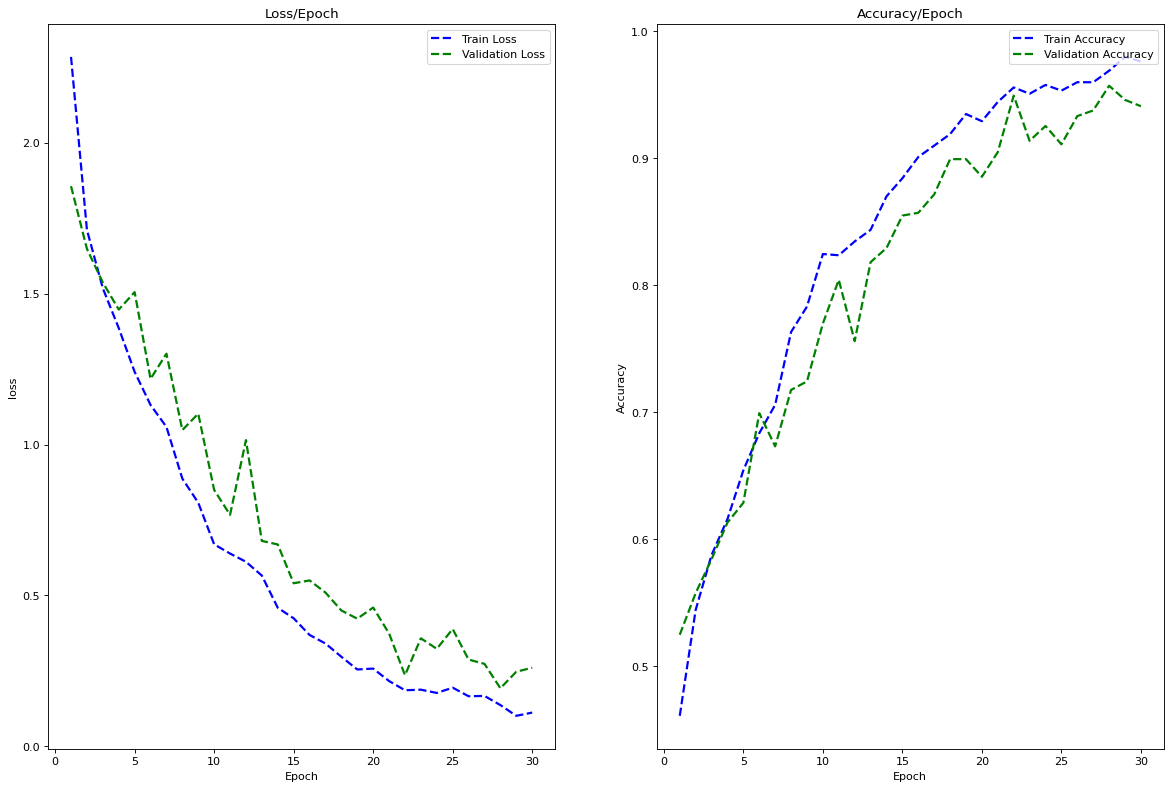

In [9]:
s2s.train()

In [12]:
torch.save(s2s.state_dict(),'saved.pt')

In [13]:
test_words_list, test_inflection_lists, test_feature_list, _, _, _, _, _, _ = file_preprocess(test_file)

words_list1 = boundary_appender(test_words_list)
tempo = test_inflection_lists
inflection_list1 = boundary_appender(tempo)

word_encode_list1 = sentence_encoder(words_list1, char_to_index)
inflection_encode_list1 = sentence_encoder(inflection_list1, char_to_index)

feat_encode_list1  = sentence_pad(sentence_encoder(test_feature_list, feature_to_index), max_feature_length)



final_acc = 0;
count=0;
for index in range(0, len(word_encode_list1)):
    
#     test_word = Variable(torch.tensor(word_encode_list1[index]).view(1,-1)).cuda()
#     test_feat = Variable(torch.FloatTensor(feat_encode_list1[index]).view(1, -1)).cuda()
#     test_label = Variable(torch.FloatTensor(inflection_encode_list1[index]).view(1, -1)).cuda()

    test_word = [word_encode_list1[index]]
    test_feat = [feat_encode_list1[index]]
    test_label = [inflection_encode_list1[index]]
    
    test_word, test_label, max_len = source_taget_equal_length_maker(test_word,test_label)
    test_word = torch.tensor(test_word).to(device)
    test_label = torch.tensor(test_label).to(device)
    test_feat = torch.FloatTensor(test_feat).to(device)

    predic_out,ac = s2s.test_model(test_word, test_feat,test_label,device,max_len)
    final_acc = final_acc+ac
    if ac==1:
      count=count+1;
    print(index+1)
    print('Actual    :\t',"".join(test_inflection_lists[index][1:-1]))
    print('Prediction:\t',"".join(predic_out))
    print(ac)
    print('')
    
    
    
    

print(final_acc/len(word_encode_list1))
print(count)





1
Actual    :	 খেয়েছিস
Prediction:	 খাচ্ছিস
0.2

2
Actual    :	 ভরবো
Prediction:	 ভরবো
1.0

3
Actual    :	 ভালবাসছিলি
Prediction:	 ভালবাসছিলে
0.9166666666666666

4
Actual    :	 ঘটনার
Prediction:	 ঘটনান
0.8571428571428571

5
Actual    :	 কাটতিস
Prediction:	 কাটতিস
1.0

6
Actual    :	 হাত মারতে
Prediction:	 হাত মারতে
1.0

7
Actual    :	 প্রমাণ করেছিস
Prediction:	 প্রমাণ করেছিস
1.0

8
Actual    :	 ঘৃণা করলে
Prediction:	 ঘৃণা করে
0.7272727272727273

9
Actual    :	 জ্বালাতন করছিলে
Prediction:	 জ্বালাতন করছিলে
1.0

10
Actual    :	 চিনবেন
Prediction:	 চেনবেন
0.875

11
Actual    :	 চালিয়েছে
Prediction:	 চালিয়েছে
1.0

12
Actual    :	 বৃষ্টি হচ্ছেন
Prediction:	 বৃষ্টি হচ্ছেন
1.0

13
Actual    :	 রেখেছিলে
Prediction:	 রেখেছিলে
1.0

14
Actual    :	 ভাবছি
Prediction:	 ভাবাস
0.7142857142857143

15
Actual    :	 জাগিয়েছিলি
Prediction:	 জাগিয়েছিলি
1.0

16
Actual    :	 গেতেন
Prediction:	 গেতেন
0.875

17
Actual    :	 ডিফ্র্যাগমেন্ট করলি
Prediction:	 ডিফ্র্যাগমেন্ট করিস
0.9047619047619048

18
Actual 